In [115]:
import numpy as np 
from matplotlib import pyplot as plt
from tqdm import tqdm

In [116]:
def HT(x, K):
    '''
    Hard thresholding operator keeps the s highest in magnitude component of a vector and collapse to zero all the others
    '''

    # Retrieve the indeces of s highest in magnitude components of x (argsort is increasing so [:-s] keeps the s highest ones)
    idxs = np.argsort(np.abs(x))[-K:]

    # Initialize an all zeros vector and store the retrieved component of x in the corresponding indices
    X = np.zeros(x.shape[0])
    X[idxs] = x[idxs]
    return X

In [117]:
def NIHT(
        y, 
        D, 
        K, 
        c = 0.01, 
        maxiter = 100, 
        projection = 'Clip', 
        normalization = 'Column', 
        faster = True
    ):

    #########################################################

    # Ensure approximately RIP property for the basis via SVD

    U, S, V = np.linalg.svd(D, full_matrices=False)

    if projection == 'Clip':
        S = np.clip(S, None, 1.0)
    elif projection == 'Proxy':
        S /= np.linalg.norm(S)

    D = U @ np.diag(S) @ V

    # Normalize columns 
    if normalization == 'Column':
        D /= np.linalg.norm(D, axis = 0)
    elif normalization == 'Full':
        D /= np.linalg.norm(D)

    #########################################################

    x = np.zeros((D.shape[1]))
    Lambda = np.nonzero(HT(D.T @ y, K))[0]

    kappa = 1/(1-c) + 1e-5

    for it in tqdm(range(maxiter)):

        g = np.copy(D.T @ (y - D @ x))
        mu = np.linalg.norm(g[Lambda]) **2 / np.linalg.norm(D[:,Lambda] @ g[Lambda]) **2
        
        x_hat = np.copy(HT(x + mu * g, K))
        Lambda_hat = np.copy(np.nonzero(x_hat)[0])

        if (Lambda == Lambda_hat).all():
            x = np.copy(x_hat)
        
        else:
            if mu <= (1 - c) * (np.linalg.norm(x - x_hat)) ** 2 / np.linalg.norm(D @ (x_hat - x)) ** 2:
                x = np.copy(x_hat)
            else:
                if faster:
                    mu = (1 - c) * (np.linalg.norm(x - x_hat)) ** 2 / np.linalg.norm(D @ (x_hat - x)) ** 2
                    x_hat = np.copy(HT(x + mu * g, K))
                else:
                    while mu >= (1 - c) * (np.linalg.norm(x - x_hat)) ** 2 / np.linalg.norm(D @ (x_hat - x)) ** 2:
                        mu = mu / (kappa * (1-c))
                        x_hat = np.copy(HT(x + mu * g, K))
                        
            Lambda = np.copy(np.nonzero(x_hat)[0])
            x = np.copy(x_hat)
                
    return x

In [118]:
x = np.zeros(200)
x[np.random.choice(200, 4)] = np.random.normal(scale=0.5, size = 4)

A = np.random.normal(size = (150,200))

y = A @ x

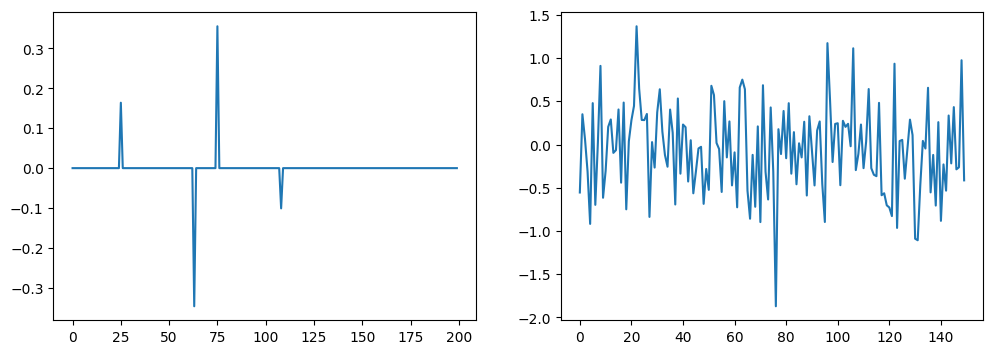

In [119]:
_, axs = plt.subplots(1,2, figsize =(12,4))
axs[0].plot(x)
axs[1].plot(y)

100%|██████████| 100/100 [00:00<00:00, 2393.52it/s]


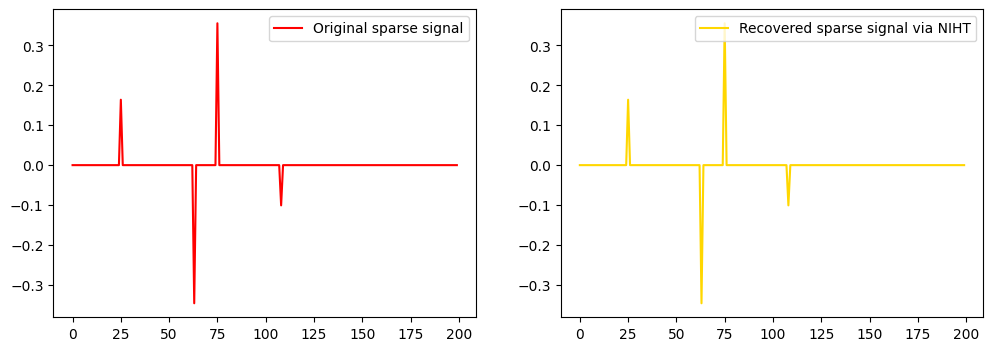

In [120]:
_, axs = plt.subplots(1,2, figsize =(12,4))
axs[0].plot(x, color='red', label = 'Original sparse signal')
axs[0].legend()
axs[1].plot(NIHT(y, A, 4, projection = None, normalization=None, faster=True), color = 'gold', label = 'Recovered sparse signal via NIHT')
axs[1].legend()